# Activity 3.1: Exploring preconditioning of GMRES

4 points

Key takeaways:

- The difference between left and right preconditioning
- Why _non-stationary_ preconditioners have problems in non-flexible Krylov methods

**Collaboration statement:**

In [1]:
%pip install numpy scipy matplotlib

from scipy.sparse.linalg import gmres, minres, LinearOperator, spsolve
from scipy.sparse import csr_matrix, rand, eye, diags
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


Let's create a random matrix `A` and right hand side `b`:

In [2]:
n = 1000
density = 0.01
A = rand(n, n, density) + 2.75*eye(n)
A = A - 0.9 * 0.5 * (A - A.T)
b = np.random.rand(n)

`scipy.sparse.linalg.gmres` is an implementation of GMRES.  We can use it to solve systems in `A`:

In [4]:
xhat, info = gmres(A, b, tol=1.e-3)
print(info)
print("residual norm", np.linalg.norm(b - A @ xhat))
print("right hand side norm", np.linalg.norm(b))
print("relative reduction in residual norm", np.linalg.norm(b - A @ xhat) / np.linalg.norm(b))

0
residual norm 0.017220293596628383
right hand side norm 18.25086846637006
relative reduction in residual norm 0.0009435328312381044


**Activity 1 (2 points):** First implement left- and right-preconditioned gmres for yourself by calling `gmres` with the appropriate right hand side, operator, and returning the appropriate solution.

**Note:** gmres accepts a preconditioner argument `M`, but you **should not use it**.  We are pretending that argument is not available.

_Hint:_ you may want to use the following code, which wraps up the product of two linear operators as a composite operator.

In [6]:
def product_op(A, B, dtype=np.float64):
    return LinearOperator((A.shape[0], B.shape[1]), matvec=lambda x: A @ (B @ x), dtype=dtype)

In [8]:
def gmres_left_preconditioned(A, b, x0, M, **kwargs):
    """
    Args:
        A (linear operator): matrix
        b (ndarray): rhs
        x0 (ndarray): initial guess
        M (linear operator): preconditioner
        kwargs: should be passed to `gmres`
    Returns:
        (ndarray, info): the solution, plus the info object returned by `gmres`
    """
    x, info = gmres(product_op(M,A),M @ b,x0=x0, **kwargs)
    return x, info

def gmres_right_preconditioned(A, b, x0, M, **kwargs):
    """
    Args:
        A (linear operator): matrix
        b (ndarray): rhs
        x0 (ndarray): initial guess
        M (linear operator): preconditioner
        kwargs: should be passed to `gmres`
    Returns:
        (ndarray, info): the solution, plus the info object returned by `gmres`
    """
    #~~u0 = M.inv(x0)~~
    r0 = b - A @ x0
    # A(x0 + p) = b
    # A p = r0
    # A M u = r0
    # p = M u
    # x = x0 + Mu
    u, info = gmres(product_op(A, M), r0, x0=np.zeros(b.shape), **kwargs)
    x = x0 + M @ u
    return x, info

In [9]:
# If we use an exact preconditioner they should both return the true solution after one iteration
xtrue = spsolve(A, b)
Ainv = np.linalg.inv(A.toarray())
x0 = np.random.randn(n)
xleft, infoleft = gmres_left_preconditioned(A, b, x0, Ainv, restart=1, maxiter=1)
assert(infoleft == 0)
assert(np.linalg.norm(xleft - xtrue) < 1.e-8)
xright, inforight = gmres_right_preconditioned(A, b, x0, Ainv, restart=1, maxiter=1)
assert(inforight == 0)
assert(np.linalg.norm(xright - xtrue) < 1.e-8)


**Activity 2 (1 point):** `scipy.sparse.linalg.gmres` does take a preconditioning argument `M`, but the documentation doesn't say whether it is left- or right-preconditioned, and the documentation is unclear about whether the stopping tolerance depends on the $\ell_2$ or preconditioned norm.  Compare `gmres(M=...)` to your `gmres_left_preconditioned` and `gmres_right_preconditioned` and say which side `gmres` preconditions.

_Hint 1:_ the two are equivalent with exact precontioning $M = A^{-1}$ and with no preconditioning $M = I$, you might want to use a random diagonal preconditioner to create a situation where they are different.

_Hint 2:_ Make sure you use a fixed `maxiter` and `restart` in your comparison.

In [13]:
M = diags(np.random.rand(n))
xleft, _ = gmres_left_preconditioned(A, b, np.zeros(n), M, restart=1, maxiter=1)
xright, _ = gmres_right_preconditioned(A, b, np.zeros(n), M, restart=1, maxiter=1)
x, _ = gmres(A, b, x0=np.zeros(n), M=M, restart=1, maxiter=1)
print(np.linalg.norm(xleft - x))
print(np.linalg.norm(xright - x))

0.0
0.30441384518036274


YOUR ANSWER HERE

**Activity 3 (1 point):** An iterative method `KSP(A,r)` applied to a right hand side can be thought of as an approximation of $A^{-1}$, but is a _non-stationary_ approximation of $A^{-1}$.  It won't satisfy linearity exactly, so `KSP(A, alpha * r + beta * q)` $\neq$ `alpha * KSP(A, r) + beta * KSP(A, q)`.  Because of this,
there is no guarantee that when we reconstruct $x$ from a Krylov subspace by $x = V y$ that `A @ KSP(A, x) == A @ KSP(A, V @ y)`, which can cause problems for `gmres`.  (This is why FGMRES was created)

Let's say we want to precondition $A$ with an approximate inverse of its symmetric component, which does make the system well-conditioned in this case.

In [14]:
Asym = 0.5 * (A + A.T)

print(np.linalg.cond(A.toarray()))
print(np.linalg.cond(np.linalg.solve(Asym.toarray(), A.toarray())))

80.23534434406012
3.7593731918183555


The following code creates an approximation to $A_{sym}^{-1}$ using minres to a fixed tolerance.

In [15]:
def minres_op(Asym, tol):
    """Create a LinearOperator that aplies MINRES to approximately solve Asym x = r to a given relative tolerance"""
    return LinearOperator(Asym.shape, matvec=lambda r: minres(Asym, r, x0=np.zeros(Asym.shape[0]), tol=tol)[0], dtype=Asym.dtype)

Here is code to let us collect residuals from `gmres`

In [16]:
class MonitorResiduals(object):
    def __init__(self, array):
        self.array = array
        
    def __call__(self, pr_norm):
        self.array.append(pr_norm)

**Modify the plot below** by adding convergence histories for different tolerances on the inner MINRES solve to see how exact the tolerance has to be before the minres preconditioning of gmres has stable convergence. 

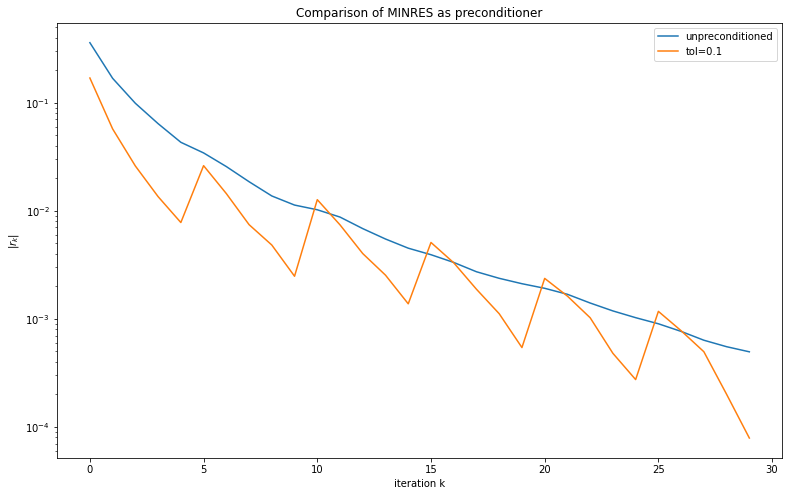

In [20]:
tol = 1.e-1
M = minres_op(Asym, tol)
unprec_residuals = []
prec_residuals = {}
prec_residuals[tol] = []
_ = gmres_right_preconditioned(A, b, np.zeros(b.shape), M, tol=0., restart=5, maxiter=6,
                               callback=MonitorResiduals(prec_residuals[tol]), callback_type='pr_norm')
_ = gmres(A, b, np.zeros(b.shape), tol=0., restart=5, maxiter=6,
          callback=MonitorResiduals(unprec_residuals), callback_type='pr_norm')

ax = plt.figure(figsize=(13,8)).gca()
ax.set(xlabel='iteration k')
ax.set(ylabel=r'$\|r_k\|$')
ax.set(title='Comparison of MINRES as preconditioner')
ax.semilogy(unprec_residuals, label='unpreconditioned')
ax.semilogy(prec_residuals[tol], label='tol={}'.format(tol))
ax.legend()